# Reporting and Communicating Data Using Python

A lot of people think the work of a Data Scientist or someone working in a data role is to be able to spin up a [Apache Hadoop](https://hadoop.apache.org/) cluster and using [Apache Spark](http://spark.apache.org/) to spend 12 hours fitting an [XGBoost](https://xgboost.readthedocs.io/en/latest) model. This may be true some of the time, but really [80% of time is spent preparing data](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/).

Neither of these are topics for today. I want to talk about communicating data. All the effort put towards working with data is wasted if nobody ever uses it. If decisions are to be made with data, it first needs to be communicated\!

This will focus on [Descriptive Statistics](https://en.wikipedia.org/wiki/Descriptive_statistics), something happened and we want to understand it, but the same ideas hold true for [Predictive Statistics](https://en.wikipedia.org/wiki/Predictive_analytics) or [Prescriptive Statistics](https://en.wikipedia.org/wiki/Prescriptive_analytics).

These same concepts are at play regardless of platform being used, be it Python, R, Scala, Excel, JMP, Minitab, SPSS, etc.

To discuss:
* Always plot your data
* Reporting confidence intervals and p-values
* Some neat jupyter tricks (interactivity, HTML, hide code)

Other things to consider:
* Consistency across roles, multiple Data Scientists and Analysts should use similar (if not the same) methods, which should also be available to other technical persons who also need to work with data
* Know your audience, what makes sense for communicating with other Data Persons, Technical Persons, Business Persons, and the general public aren't always the same thing
* Label and scale your axes, one of the "best" ways to lie to people with data is to misrepresent it with unlabeled axes or messing with the scale of the axis
* Colorblindness is fairly common, keep this in mind when selecting colors

In [1]:
import os
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from datetime import datetime
from datetime import timedelta
import itertools

PlotWidth = 6

%matplotlib inline

### The example data
Here are some dummy continuous numerical and catagorical data for use in the demonstration. They are all drawn from a normal distribution, but in a real world case we might not know that and would want to do some work to [demonstrate](https://en.wikipedia.org/wiki/Normal_probability_plot) the [data follow a normal distribution](https://en.wikipedia.org/wiki/Normality_test).

In [2]:
np.random.seed(1729)
cols = ['Trial', 'Numerical Response #1', 'Numerical Response #2', 'Catagorical Response']
Trials = ['Control', 'Treatment A', 'Treatment B', 'Treatment C']
Means = [100,105,120,110]
StandardDeviations = [15,15,30,5]
df = pd.DataFrame(columns=cols)
numRepeats = 10
for i in np.arange(4):
    Yn1 = np.random.normal(Means[i],StandardDeviations[i],numRepeats)
    Yn2 = Yn1 + (np.random.rand(numRepeats)-.5)*10
    Yc = np.random.choice(['Left', 'Right'],numRepeats)
    df = df.append(pd.DataFrame((np.array([np.repeat(Trials[i],numRepeats), Yn1, Yn2, Yc]).T), columns=cols)).reset_index(drop=True)
df['Numerical Response #1'] = df['Numerical Response #1'].astype('float')
df['Numerical Response #2'] = df['Numerical Response #2'].astype('float')

display(df)

,Trial,Numerical Response #1,Numerical Response #2,Catagorical Response
0,Control,89.689908,85.359379,Left
1,Control,87.685079,90.018988,Left
2,Control,124.785413,124.883312,Left
3,Control,91.370604,88.646340,Right
4,Control,116.484516,114.899027,Right
5,Control,113.889190,114.009122,Left
6,Control,85.098793,89.706022,Left
7,Control,87.126683,88.267227,Right
8,Control,101.123301,103.647307,Left
9,Control,107.940333,111.944291,Left


### Common plots

In general it's a good idea to always plot your data. Plotting data is a fast way of telling if something is wrong with the data and gives a sense for what's you're working with. It's an important part of [Exploratory Data Analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis).

Some of the basic plots that are almost always worth plotting when first working with data are:
* [Box plots](https://en.wikipedia.org/wiki/Box_plot) (for continuous vs. categorical data)
* [Histograms](https://en.wikipedia.org/wiki/Histogram) (for continuous vs. catagorical data)
* [Scatterplots](https://en.wikipedia.org/wiki/Scatter_plot) (for continuous vs. continuous data)
* [Mosaic plots](https://en.wikipedia.org/wiki/Mosaic_plot) (for catagorical vs. catagorical data or displaying a [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix))
* [Line plots](https://en.wikipedia.org/wiki/Line_chart) (for time-series data)
* [Pareto plots](https://en.wikipedia.org/wiki/Pareto_chart) (like a bar chart, but ordered tallest-to-shortest to determine individual contributions)

Be careful with:
* [Bar charts](https://en.wikipedia.org/wiki/Bar_chart) (axis scale is incredibly important because humans will compare areas and these can become misleading)
* [Pie charts](https://en.wikipedia.org/wiki/Pie_chart) (Again humans will compare areas, a pareto plot is almost always better, especially once more than 4-5 factors are included)
* Anything 3D (unless you can interact with it and rotate it in real time)

### Box plots
[Box plots](https://en.wikipedia.org/wiki/Box_plot) are a great tool for visualizing the variability and placement of data. It can also be used for a first pass at data that might be [outliers](https://en.wikipedia.org/wiki/Outlier) (which is a rabbit hole I don't want to go down here).

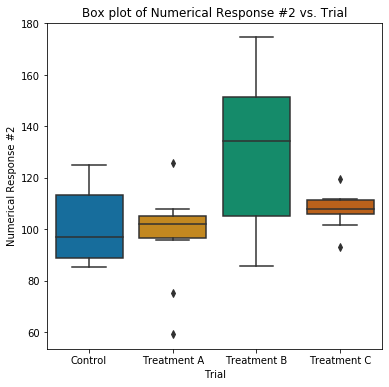

In [3]:
plt.figure(figsize=(PlotWidth,PlotWidth))
sns.boxplot(x='Trial', y='Numerical Response #2', data=df, palette='colorblind')
plt.title('Box plot of Numerical Response #2 vs. Trial')
plt.show()

Looking at these data, we can tell a couple things right off the bat:
* Treatments A and C might have some candidates to examime as outliers
* Treatments A and C are less variable than the control
* Treatment B is a lot more variable than other Treatments
* If we're trying to get our Numerical Response to be a higher value than the control, there is something about Treatment B that might do it, but consistency is an issue

### Histograms
Using the seaborn library, [distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html) is nice because it plots the [histogram](https://en.wikipedia.org/wiki/Histogram) bars and the [probability density function (pdf)](https://en.wikipedia.org/wiki/Probability_density_function).

Histograms become more useful when there are a lot of data. This example only has n=10 for each Treatment, so they're of limited usefulness.

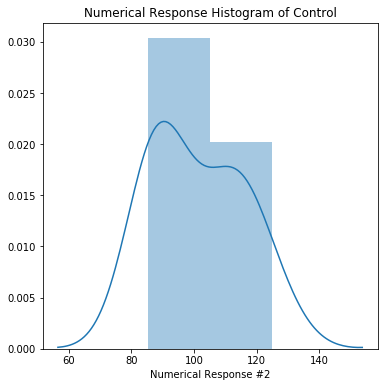

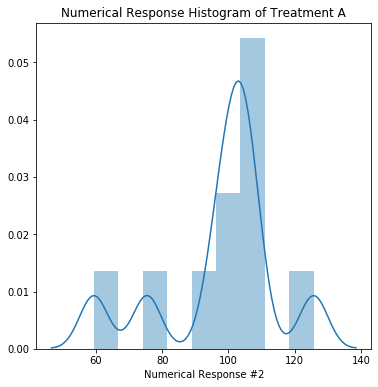

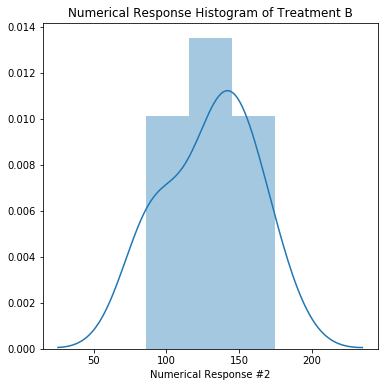

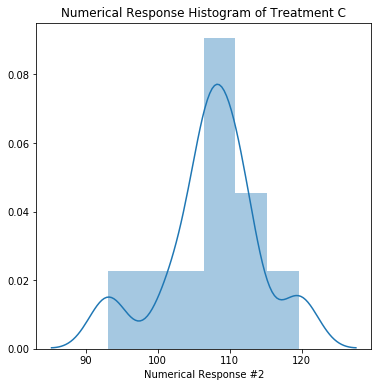

In [4]:
for trial in df['Trial'].unique():
    plt.figure(figsize=(PlotWidth,PlotWidth))
    sns.distplot(df.loc[df['Trial'] == trial, 'Numerical Response #2'])
    plt.title(f'Numerical Response Histogram of {trial}')
    plt.show()

### Scatter plots
Using the seaborn library, [regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html) is nice because plots both the scatter plot data and a [regression line](https://en.wikipedia.org/wiki/Linear_regression). Unfortunately it doesn't allow multiple data series on the same plot, but [scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html?highlight=scatterplot) can.

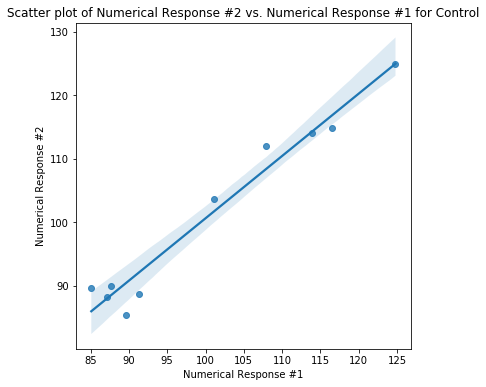

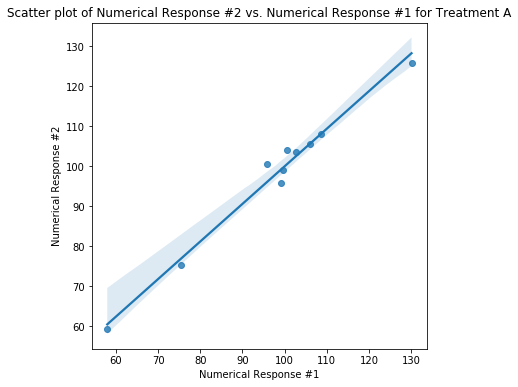

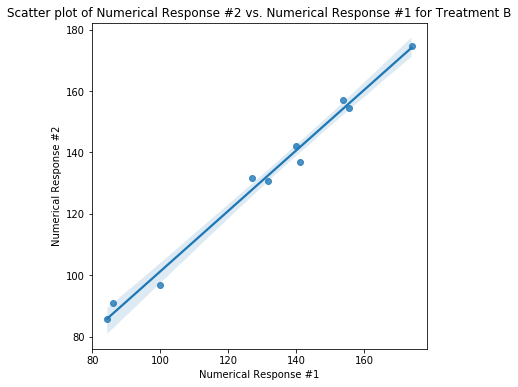

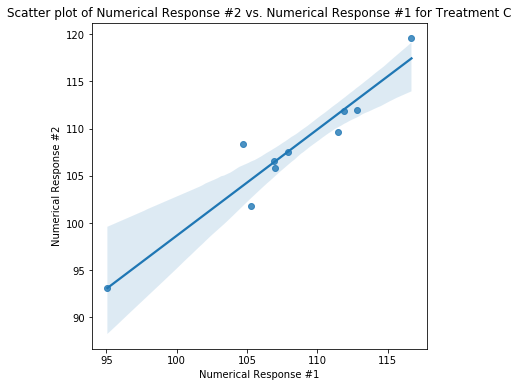

In [5]:
for trial in df['Trial'].unique():
    plt.figure(figsize=(PlotWidth,PlotWidth))
    sns.regplot(x='Numerical Response #1', y='Numerical Response #2', data=df.loc[df['Trial'] == trial])
    plt.title(f'Scatter plot of Numerical Response #2 vs. Numerical Response #1 for {trial}')
    plt.show()

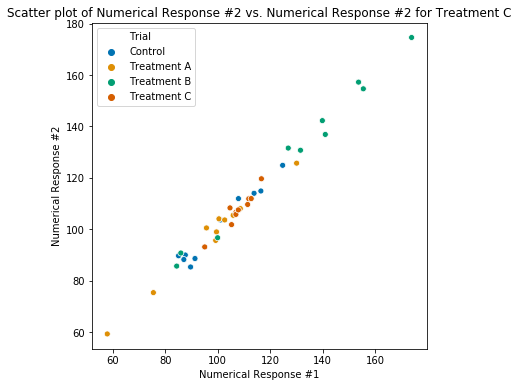

In [6]:
plt.figure(figsize=(PlotWidth,PlotWidth))
sns.scatterplot(x='Numerical Response #1', y='Numerical Response #2', data=df, hue='Trial', palette='colorblind')
plt.title(f'Scatter plot of Numerical Response #2 vs. Numerical Response #2 for {trial}')
plt.show()

### Aggregating descriptive data
So we have a bunch of data and want to group it by trial and it needs to be communicated. Data tables are a terrible way to communicate data on their own, but packaged with one or more of the plots from above, it can give some end-user a way to use the data. If your goal is to get people's eyes to glaze over in a meeting, put up a data table without a plot.

Jupyter notebooks allow pandas dataframes to be displayed in an appealing way, so here are a couple descriptive statistics in a table, subject to modification based on needs.

Here we aggregated data for our "Numerical Response \#2":
* The count, how many rows of data belong to which trial
* The median value
* The average (mean) value
* Standard Deviation and Standard Error
* 95% confidence intervals for the mean

In [7]:
alpha = 0.05
for metric in ['Numerical Response #2']:
    dfForAggregate = df.groupby(['Trial'])[metric]
    dfAggregateTable = pd.DataFrame()
    dfAggregateTable['Count'] = dfForAggregate.count()
    dfAggregateTable['Median'] = dfForAggregate.median()
    dfAggregateTable['Mean'] = dfForAggregate.mean()
    dfAggregateTable['Standard Deviation'] = dfForAggregate.std()
    dfAggregateTable['Standard Error'] = dfAggregateTable['Standard Deviation']/np.sqrt(dfAggregateTable['Count'])
    dfAggregateTable['Lower 95%'] = dfAggregateTable['Mean'] - norm.ppf(1-alpha/2)*dfAggregateTable['Standard Error']
    dfAggregateTable['Upper 95%'] = dfAggregateTable['Mean'] + norm.ppf(1-alpha/2)*dfAggregateTable['Standard Error']
    dfAggregateTable.reset_index(inplace=True)
    
display(dfAggregateTable.style.hide_index())

Trial,Count,Median,Mean,Standard Deviation,Standard Error,Lower 95%,Upper 95%
Control,10,96.833148,101.138102,14.402661,4.554521,92.211404,110.064799
Treatment A,10,102.091856,97.691622,18.296250,5.785782,86.351697,109.031547
Treatment B,10,134.235272,130.110748,30.073821,9.510177,111.471143,148.750353
Treatment C,10,107.939290,107.636296,6.941188,2.194996,103.334182,111.938409


### Hypothesis Testing
So this table is great, but it's not obvious from looking at it if any of the treatments have a [statistically significant difference](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) over the control.

There are a couple of different ways to do this depending on the goal of the analysis:
* Test each factor against each other factor. This has an issue in that when there are a lot of factors being compare to one another, which opens up the [Multiple Comparison Problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) and [p-hacking](https://en.wikipedia.org/wiki/Data_dredging).
* One way to avoid this issue is to use [Tukey's HSD (honestly significant difference) test](https://en.wikipedia.org/wiki/Tukey%27s_range_test), which does a pairwise test for every pair of factors being compared and adjust based on number of factors being compared.
* Another way when there is one control everything is to be compared to is to use [Dunnett's test](https://en.wikipedia.org/wiki/Dunnett%27s_test). Unfortunately I have been unable to find a Python library that does this out of the box. One day I decided I'd implement it myself only to notice that I needed a Python library for calculating values from the [Multivariate t-distribution](https://en.wikipedia.org/wiki/Multivariate_t-distribution), which I also have been unable to find. If anyone is aware of a Python library that can do either or both of these please let me know!

For this example I'm going to use the first approach for simplicity.

In [8]:
alpha = 0.05
for metric in ['Numerical Response #2']:
    dfForAggregate = df.groupby(['Trial'])[metric]
    dfAggregateTable = pd.DataFrame()
    dfAggregateTable['Count'] = dfForAggregate.count()
    dfAggregateTable['Median'] = dfForAggregate.median()
    dfAggregateTable['Mean'] = dfForAggregate.mean()
    dfAggregateTable['Standard Deviation'] = dfForAggregate.std()
    dfAggregateTable['Standard Error'] = dfAggregateTable['Standard Deviation']/np.sqrt(dfAggregateTable['Count'])
    dfAggregateTable['Lower 95%'] = dfAggregateTable['Mean'] - norm.ppf(1-alpha/2)*dfAggregateTable['Standard Error']
    dfAggregateTable['Upper 95%'] = dfAggregateTable['Mean'] + norm.ppf(1-alpha/2)*dfAggregateTable['Standard Error']
    dfAggregateTable.reset_index(inplace=True)
    
    dfAggregateTable['p-value vs. Control'] = ''
    myControl = df.loc[df['Trial'] == 'Control', metric]
    for treatment in df['Trial'].unique():
        myTreatment = df.loc[df['Trial'] == treatment, metric]
        mypvalue = stats.ttest_ind(myControl.to_numpy(), myTreatment.to_numpy()).pvalue
        dfAggregateTable.loc[dfAggregateTable['Trial'] == treatment, 'p-value vs. Control'] = mypvalue
    
display(dfAggregateTable.style.hide_index())


Trial,Count,Median,Mean,Standard Deviation,Standard Error,Lower 95%,Upper 95%,p-value vs. Control
Control,10,96.833148,101.138102,14.402661,4.554521,92.211404,110.064799,1.000000
Treatment A,10,102.091856,97.691622,18.296250,5.785782,86.351697,109.031547,0.645360
Treatment B,10,134.235272,130.110748,30.073821,9.510177,111.471143,148.750353,0.013239
Treatment C,10,107.939290,107.636296,6.941188,2.194996,103.334182,111.938409,0.214986


So Treatment B has a low enough p-value where it may be possible to conclude that it's statistically significantly different from the Control. Treatment B also has a very large standard deviation relative to the Control, so that could be a problem.

### Making it presentable

This table can also be cleaned up so that it doesn't contain so many decimal points. We can also highlight p-values at certain thresholds. I'm highlighting p-values in the way [JMP](https://www.jmp.com/en_us/home.html) does because if I'm not using Python or Excel to solve a problem, it's because I'm using JMP and consistency is nice.

In [9]:
def pValueFormating(pvalue):
    pvalue = float(pvalue)
    if pvalue > 0.05:
        color = 'black'
    elif pvalue > 0.01:
        color = 'red'
    elif pvalue >= 0:
        color = 'orange'
    else:
        color = 'black'
    return 'color: {0}'.format(color)

display(dfAggregateTable.style\
        .hide_index() \
        .format({x: '{:,.1f}' for x in ['Median', 'Mean', 'Standard Deviation', 'Standard Error', 'Lower 95%', 'Upper 95%']}) \
        .format({'p-value vs. Control': '{:,.4f}'}) \
        .applymap(pValueFormating, subset='p-value vs. Control') \
        )

Trial,Count,Median,Mean,Standard Deviation,Standard Error,Lower 95%,Upper 95%,p-value vs. Control
Control,10,96.8,101.1,14.4,4.6,92.2,110.1,1.0000
Treatment A,10,102.1,97.7,18.3,5.8,86.4,109.0,0.6454
Treatment B,10,134.2,130.1,30.1,9.5,111.5,148.8,0.0132
Treatment C,10,107.9,107.6,6.9,2.2,103.3,111.9,0.2150


### A couple other neat Jupyter tricks
* Jupyter notebooks can be [interactive](https://ipywidgets.readthedocs.io/en/stable/examples/Lorenz%20Differential%20Equations.html)
* You can use HTML in Jupyter notebooks
* All the code cells can be hidden in Jupyter notebooks


#### HTML Example

Since Jupyter notebooks can be exported as HTML, they can be used for reports. This gives an opportunity to use HTML and Javascript to clean up or spice up the report.

For example, page anchors can be used to create a Table of Contents. This can also be done with Markdown, but you might not know what anchors you need before you run the script.

In [10]:
from IPython.display import HTML
someHTMLstring = '<a href="#myanchor", name="myanchor">A <b>hyperlink shortcut</b> to a spot I want in the page!</a>'

display(HTML(someHTMLstring))


Another example is using Javascript to toggle the code cells on/off. This lets the Markdown Cells, plots, and tables to be displayed without the end-user having to scroll through mountains of code he or she might not be interested in.

Full credit to [harshil](https://stackoverflow.com/users/4244561/harshil) who [answered this on stack overflow](https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer).

In [11]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')